# Tabularize time series

In this assignment, your task is to convert **time series data** into a **tabular data set**.

You need to create suitable input features from a time series containing weekly sales to be able to forecast sales for the next week.

To prepare the dataset for this assignment, please follow the guidelines in the notebook `02-create-online-retail-II-datasets.ipynb` in the `01-Create-Datasets` folder.

In [241]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime, timedelta
import holidays

from feature_engine.creation import CyclicalFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [242]:
# setting my own output (print) format

sep = ('_' * 24) + '\n'

def myout(msg, x=None):
    print(f'{sep}{msg}\n')
    if x is not None:
        print(f'{x}\n\n')

In [243]:
# load weekly sales dataset

filename = "../../Datasets/online_retail_dataset.csv"

df = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
)

df.rename(columns={"United Kingdom": "sales"}, inplace=True)
df.sort_index(inplace=True)

df.head()

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


# Data analysis

First, explore the time series.


In [244]:
myout('A summary of the data:')
df.info()

myout('Index of the data:', df.index)

msk_actual = df['sales'] > 0
myout(f'Zero-sales weeks:', df_weekly.index[~msk_actual].isocalendar().week)

myout('Descriptive statistics of the weekly actual sales:', df.loc[msk_actual, "sales"].describe())


________________________
A summary of the data:

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 106 entries, 2009-12-06 to 2011-12-11
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   sales   106 non-null    float64
dtypes: float64(1)
memory usage: 1.7 KB
________________________
Index of the data:

DatetimeIndex(['2009-12-06', '2009-12-13', '2009-12-20', '2009-12-27',
               '2010-01-03', '2010-01-10', '2010-01-17', '2010-01-24',
               '2010-01-31', '2010-02-07',
               ...
               '2011-10-09', '2011-10-16', '2011-10-23', '2011-10-30',
               '2011-11-06', '2011-11-13', '2011-11-20', '2011-11-27',
               '2011-12-04', '2011-12-11'],
              dtype='datetime64[ns]', name='week', length=106, freq=None)


________________________
Zero-sales weeks:

week
2010-01-03    53
2011-01-02    52
Name: week, dtype: UInt32


________________________
Descriptive statistics of the 

## Plot time series

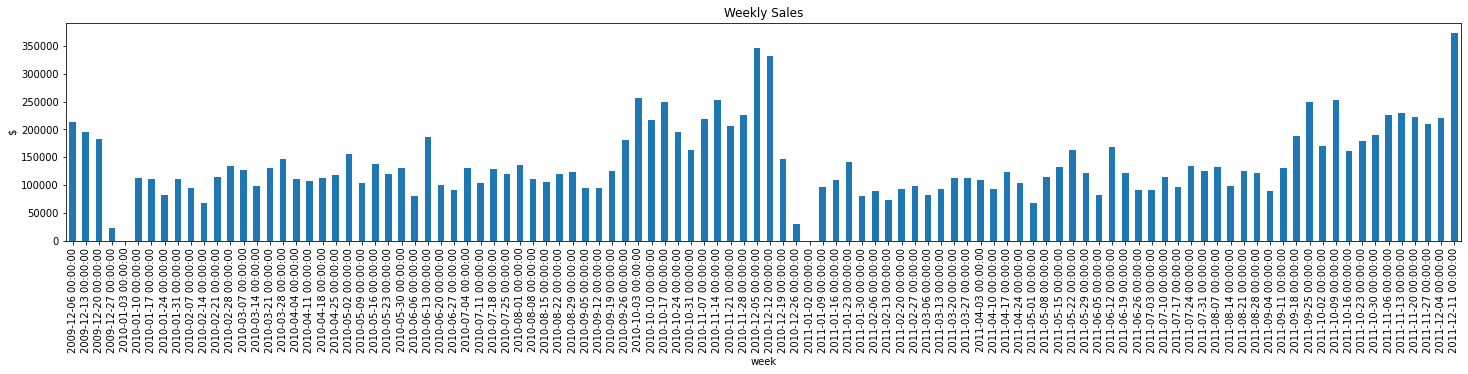

In [245]:
# Plot the time series.

# Plot the time series
df['sales'].plot.bar(figsize=(25, 4))

# Add title
plt.title('Weekly Sales')

# the y axis label
plt.ylabel('$')

plt.show()

## Missing data

Check if there are missing values in the time series.

In [246]:
myout(f'Missing values? {df["sales"].isnull().sum()>0}')

________________________
Missing values? False



## Missing timestamps

Check if there are missing timestamps in the index.

In [247]:
# Auxiliary data
df_weekly = df.asfreq("W")

myout(f'Missing week? {df_weekly["sales"].isnull().any()}')


________________________
Missing week? False



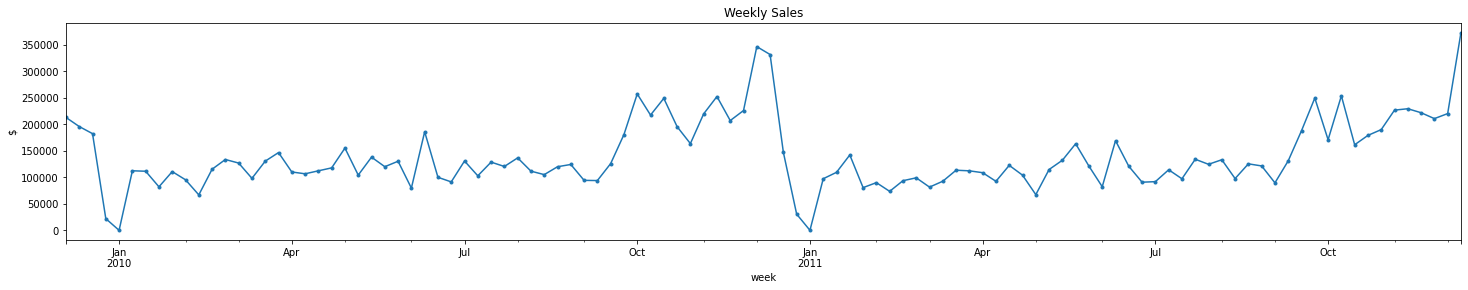

In [248]:
# Apply the forward fill method.
df_full = df_weekly.fillna(method="ffill")

# Plot the time series
ax = df_weekly['sales'].plot(linestyle="-", marker=".", figsize=[25, 4])

# plot the imputed values on top, in red.
df_full[df_weekly.isnull()]['sales'].plot(ax=ax, legend=None, marker=".", color="r")

# Add title
plt.title('Weekly Sales')

# the y axis label
plt.ylabel('$')

plt.show()


## Seasonality

Does the time series show any obvious seasonal pattern?

### Monthly sales

In [249]:
# Capture "time" in a new variable.

mo = df.index.month

mo = pd.Series(mo, index=df.index)
mo.index.name = 'month'

mo.head()

month
2009-12-06    12
2009-12-13    12
2009-12-20    12
2009-12-27    12
2010-01-03     1
Name: week, dtype: int64

Text(0, 0.5, '$')

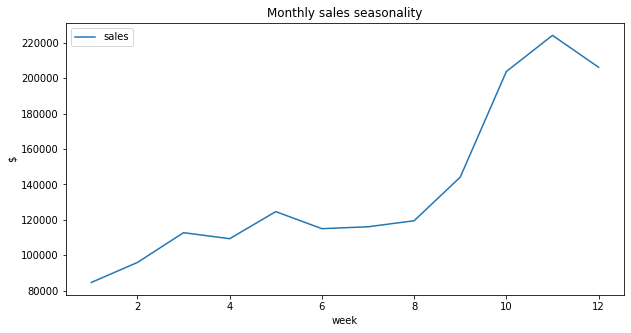

In [250]:
# Plot the average sales per month.

df.groupby(mo)[["sales"]].mean().plot(figsize=(10, 5))
plt.title("Monthly sales seasonality")
plt.ylabel("$")

### Weekly sales

In [251]:
# Capture "time" in a new variable.

we = df.index.isocalendar().week

we = pd.Series(we, index=df.index)
we.index.name = 'week'

we.head()

week
2009-12-06    49
2009-12-13    50
2009-12-20    51
2009-12-27    52
2010-01-03    53
Name: week, dtype: UInt32

Text(0, 0.5, '$')

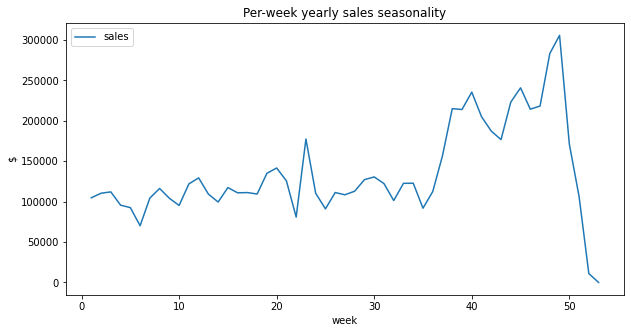

In [252]:
# Plot the average sales per week of the year.

df.groupby(we)[["sales"]].mean().plot(figsize=(10, 5))
plt.title("Per-week yearly sales seasonality")
plt.ylabel("$")

# Feature engineering

Now, let's begin to tabularize the data.

### Time-related features

In [253]:
# Setting some date features.

df["Month"] = df.index.month
df["Week"] = df.index.isocalendar().week
df["Tri"] = 1 + (df.index.month // 4)

# Is there a holiday in the week?
dt_min = df.index.values[0]
dt_max = df.index.values[-1]
target_years = df.index.year.drop_duplicates().to_list()
holis = pd.Series(holidays.UK(years=target_years).keys())
holis = pd.to_datetime(holis)
holis = holis + pd.to_timedelta(6 - holis.dt.weekday, unit='D')
holis = holis.drop_duplicates()
msk_no_newyears = (holis.dt.day > 14) | (holis.dt.month != 1)
msk_in_range = (holis >= dt_min) & (holis <= dt_max)
holis = holis.loc[msk_no_newyears & msk_in_range]
df["Holi"] = 0
df.loc[holis, "Holi"] = 1

# Nearly holiday weight
df["HoliHeat"] = \
    2 * df["Holi"] + \
    3 * df["Holi"].shift(-1, fill_value=0) + \
    df["Holi"].shift(-2, fill_value=0)

# Monthly week
msk_new_mo = df["Month"].diff().fillna(1) != 0
df["MoWth"] = np.arange(df.shape[0])
df.loc[msk_new_mo, "MoWth"] = 1 - df.loc[msk_new_mo, "MoWth"].diff().fillna(0)
df.loc[~msk_new_mo, "MoWth"] = 1
df["MoWth"] = df["MoWth"].cumsum().astype(int)

df.head(15)

,sales,Month,Week,Tri,Holi,HoliHeat,MoWth
month,,,,,,,
2009-12-06,213000.350,12,49,4,1,2,1
2009-12-13,195810.040,12,50,4,0,1,2
2009-12-20,182396.740,12,51,4,0,3,3
2009-12-27,22007.770,12,52,4,1,2,4
2010-01-03,0.000,1,53,1,0,0,1
2010-01-10,112318.850,1,1,1,0,0,2
2010-01-17,111460.470,1,2,1,0,0,3
2010-01-24,82065.331,1,3,1,0,0,4
2010-01-31,110790.591,1,4,1,0,0,5


### Lag features

In [254]:
# Moving the weekly sales values forward by 1 week,
# so that the sales amount from the previous
# week (w-1) is aligned with the current week (w),
# which is the forecasting point.

# Shift the data forward 1 Hr.
df['sales_lag_1'] = df['sales'].shift(freq="1W")

df.head()

,sales,Month,Week,Tri,Holi,HoliHeat,MoWth,sales_lag_1
month,,,,,,,,
2009-12-06,213000.35,12,49,4,1,2,1,NaN
2009-12-13,195810.04,12,50,4,0,1,2,213000.35
2009-12-20,182396.74,12,51,4,0,3,3,195810.04
2009-12-27,22007.77,12,52,4,1,2,4,182396.74
2010-01-03,0.00,1,53,1,0,0,1,22007.77


In [255]:
# Use the mean of the 3 previous weeks as input variables.

wind = (
    df[['sales']]
    .rolling(window=3, min_periods=1)
    .mean()    # Average the last 3-week values.
    .shift()   # Move the average 1 week forward
)

wind.rename(columns={'sales': '3wSalesMean'}, inplace=True)

# view of the result
wind.head(10)

,3wSalesMean
month,
2009-12-06,NaN
2009-12-13,213000.350000
2009-12-20,204405.195000
2009-12-27,197069.043333
2010-01-03,133404.850000
2010-01-10,68134.836667
2010-01-17,44775.540000
2010-01-24,74593.106667
2010-01-31,101948.217000


In [195]:
# Join the 3-week window to the original data.
myout("Shape before: ", df.shape)

df = df.merge(wind, left_index=True, right_index=True, how="left")

myout("Shape after: ", df.shape)

df.head(15)

________________________
Shape before: 

(106, 7)


________________________
Shape after: 

(106, 8)




,sales,Month,Week,Tri,Holi,HoliHeat,MoWth,3wSalesMean
week,,,,,,,,
2009-12-06,213000.350,12,49,4,1,2,1,NaN
2009-12-13,195810.040,12,50,4,0,1,2,213000.350000
2009-12-20,182396.740,12,51,4,0,3,3,204405.195000
2009-12-27,22007.770,12,52,4,1,2,4,197069.043333
2010-01-03,0.000,1,53,1,0,0,1,133404.850000
2010-01-10,112318.850,1,1,1,0,0,2,68134.836667
2010-01-17,111460.470,1,2,1,0,0,3,44775.540000
2010-01-24,82065.331,1,3,1,0,0,4,74593.106667
2010-01-31,110790.591,1,4,1,0,0,5,101948.217000


### Periodic features

In [256]:
# Create features that capture the cyclical representation.

cyclical = CyclicalFeatures(
    variables=['Month', 'Week', 'Tri', "MoWth"],  # The features we want to transform.
    drop_original=False,  # Whether to drop the original features.
)

df = cyclical.fit_transform(df)

cyclical_vars = [var for var in df.columns if var.endswith(('_sin', '_cos'))]

myout('Maximum values used for the transformation of each variable:', cyclical.max_values_)

df[cyclical_vars].head()

________________________
Maximum values used for the transformation of each variable:

{'Month': 12, 'Week': 53, 'Tri': 4, 'MoWth': 5}




,Month_sin,Month_cos,Week_sin,Week_cos,Tri_sin,Tri_cos,MoWth_sin,MoWth_cos
month,,,,,,,,
2009-12-06,-2.449294e-16,1.000000,-0.456629,0.889657,-2.449294e-16,1.000000e+00,0.951057,0.309017
2009-12-13,-2.449294e-16,1.000000,-0.348202,0.93742,-2.449294e-16,1.000000e+00,0.587785,-0.809017
2009-12-20,-2.449294e-16,1.000000,-0.234886,0.972023,-2.449294e-16,1.000000e+00,-0.587785,-0.809017
2009-12-27,-2.449294e-16,1.000000,-0.118273,0.992981,-2.449294e-16,1.000000e+00,-0.951057,0.309017
2010-01-03,5.000000e-01,0.866025,-0.0,1.0,1.000000e+00,6.123234e-17,0.951057,0.309017


### Drop missing data

In [257]:
# Determine fraction of missing data.

df_miss = df.isnull().sum().to_frame('count')
df_miss['perc'] = (100 * df_miss['count'] / df.shape[0]).round(4)

print(df_miss)

             count    perc
sales            0  0.0000
Month            0  0.0000
Week             0  0.0000
Tri              0  0.0000
Holi             0  0.0000
HoliHeat         0  0.0000
MoWth            0  0.0000
sales_lag_1      1  0.9434
Month_sin        0  0.0000
Month_cos        0  0.0000
Week_sin         0  0.0000
Week_cos         0  0.0000
Tri_sin          0  0.0000
Tri_cos          0  0.0000
MoWth_sin        0  0.0000
MoWth_cos        0  0.0000


We introduced only one NULL entry, on the 3-week windows. So we'll remove the corresponding row only.

In [258]:
myout("Data size before", df.shape)

df.dropna(inplace=True)

myout("Data size after", df.shape)


________________________
Data size before

(106, 16)


________________________
Data size after

(105, 16)




## Split data

Separate the data into training and testing sets, leaving the data after the last week of September to evaluate the forecasts, that is, in the testing set.

In [259]:
sep_dt = df.index[df['Month'] == 9].max()

X_train = df[df.index <= sep_dt]
X_test = df[df.index > sep_dt]

myout(f'Threshold date: {sep_dt}')
myout(f'X_train.shape: {X_train.shape}')
myout(f'X_test.shape: {X_test.shape}')


________________________
Threshold date: 2011-09-25 00:00:00

________________________
X_train.shape: (94, 16)

________________________
X_test.shape: (11, 16)



In [260]:
# the target variable
y_train = X_train["sales"].copy()
y_test = X_test["sales"].copy()

# remove raw time series from predictors set
X_train = X_train.drop("sales", axis=1)
X_test = X_test.drop("sales", axis=1)

myout('X_train...', X_train.head())
myout('X_test...', X_test.head())

________________________
X_train...

            Month  Week  Tri  Holi  HoliHeat  MoWth  sales_lag_1  \
month                                                              
2009-12-13     12    50    4     0         1      2    213000.35   
2009-12-20     12    51    4     0         3      3    195810.04   
2009-12-27     12    52    4     1         2      4    182396.74   
2010-01-03      1    53    1     0         0      1     22007.77   
2010-01-10      1     1    1     0         0      2         0.00   

               Month_sin  Month_cos  Week_sin  Week_cos       Tri_sin  \
month                                                                   
2009-12-13 -2.449294e-16   1.000000 -0.348202   0.93742 -2.449294e-16   
2009-12-20 -2.449294e-16   1.000000 -0.234886  0.972023 -2.449294e-16   
2009-12-27 -2.449294e-16   1.000000 -0.118273  0.992981 -2.449294e-16   
2010-01-03  5.000000e-01   0.866025      -0.0       1.0  1.000000e+00   
2010-01-10  5.000000e-01   0.866025  0.118273  0

## Naive forecast

Predict sales in the next week (t) as the value of sales in the previous week (t-1).

In [264]:
# Performance of naive forecast 
# (based on the sales from the previous week)

train_rmse = \
    mean_squared_error(
        y_train, 
        X_train["sales_lag_1"], 
        squared=False)

test_rmse = \
    mean_squared_error(
        y_test, 
        X_test["sales_lag_1"], 
        squared=False)

myout("Train RMSE:", train_rmse)

myout("Test RMSE:", test_rmse)


________________________
Train RMSE:

48097.2853793685


________________________
Test RMSE:

65327.34284108387




## Machine Learning

### Random Forests

In [265]:
rf_model = RandomForestRegressor(
    n_estimators=50,
    max_depth=3,
    random_state=0,
)

rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=3, n_estimators=50, random_state=0)

In [269]:
# Performance of random forests

rf_train_rmse = \
    mean_squared_error(
        y_train, 
        rf_model.predict(X_train), 
        squared=False)

rf_test_rmse = \
    mean_squared_error(
        y_test, 
        rf_model.predict(X_test), 
        squared=False)

myout("Train RMSE (Random Forest):", rf_train_rmse)

myout("Test RMSE (Random Forest):", rf_test_rmse)



________________________
Train RMSE (Random Forest):

25495.92666876237


________________________
Test RMSE (Random Forest):

58513.4182877306




### Linear Regression

Random Forest regression models are not very good at extrapolating values beyond those observed in the data. So let's now train a Lasso regression for comparison.

In [268]:
linear_model = Lasso(alpha=100, random_state=0)

linear_model.fit(X_train, y_train)

Lasso(alpha=100, random_state=0)

In [270]:
# Performance of linear model

lin_train_rmse = \
    mean_squared_error(
        y_train, 
        linear_model.predict(X_train), 
        squared=False)

lin_test_rmse = \
    mean_squared_error(
        y_test, 
        rf_model.predict(X_test), 
        squared=False)

myout("Train RMSE (Linear Model):", lin_train_rmse)

myout("Test RMSE (Linear Model):", lin_test_rmse)




________________________
Train RMSE (Linear Model):

36079.53079873376


________________________
Test RMSE (Linear Model):

58513.4182877306




Text(0, 0.5, 'Importance')

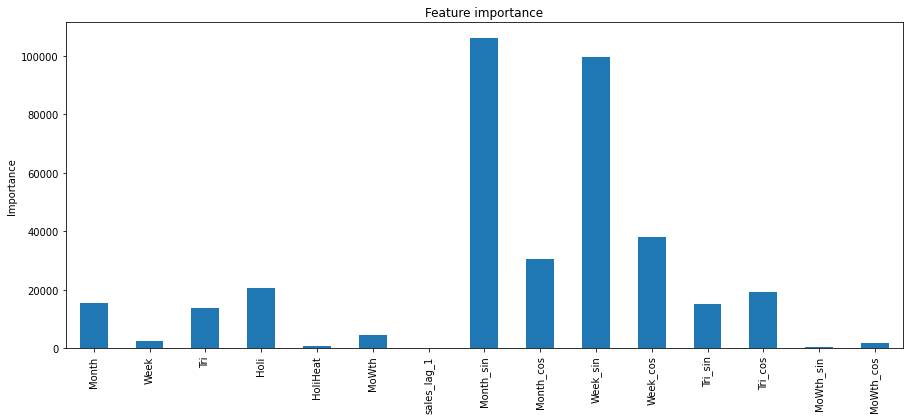

In [271]:
# Let's now plot the feature's importance
# according to the linear model.

# Create series with feature importance.
tmp = pd.Series(np.abs(linear_model.coef_))

# Let's add the variable names.
tmp.index = X_train.columns

# Let's make a bar plot.
tmp.plot.bar(figsize=(15, 6))
plt.title("Feature importance")
plt.ylabel("Importance")

#### Performances

<AxesSubplot:xlabel='Data'>

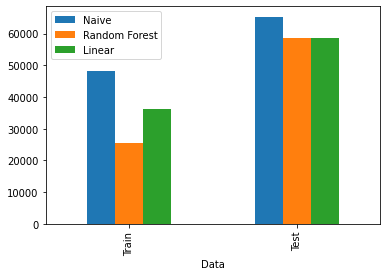

In [273]:
# creating dataframe
perf = pd.DataFrame({
    'Data': ['Train', 'Test'],
    'Naive': [train_rmse, test_rmse],
    'Random Forest': [rf_train_rmse, rf_test_rmse],
    'Linear': [lin_train_rmse, lin_test_rmse]
})
  
# plotting graph
perf.plot(x="Data", y=["Naive", "Random Forest", "Linear"], kind="bar")